In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

In [3]:
sys.path.append('/home/gjones/readout/')

In [4]:
from kid_readout.interactive import *

INFO     2016-10-06 10:36:24,449 - kid_readout.<module>:13  kid_readout logging setup with default stream handler
INFO:kid_readout:kid_readout logging setup with default stream handler


In [5]:
import glob

In [6]:
files = glob.glob('/data/readout/2016-10-*_cw_sweep_hwp_step_*.nc')
files.sort()

In [7]:
len(files)

100

In [8]:
def get_df(fn):
    ncf = NCFile(fn,cache_s21_raw=True)
    df = ncf.MMWSweepList0.to_dataframe()
    ncf.close()
    return df

In [9]:
import joblib

In [10]:
p = joblib.Parallel(n_jobs=8,verbose=5)

In [11]:
allframes = p([joblib.delayed(get_df)(fn) for fn in files])

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   55.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 12.2min finished
ERROR:/home/gjones/readout/kid_readout/kid_readout/measurement/mmw_source_sweep.pyc:NaN values encounterd while trying to fold data for stream 0. Data won't be aligned
ERROR:/home/gjones/readout/kid_readout/kid_readout/measurement/mmw_source_sweep.pyc:NaN values encounterd while trying to fold data for stream 0. Data won't be aligned
ERROR:/home/gjones/readout/kid_readout/kid_readout/measurement/mmw_source_sweep.pyc:NaN values encounterd while trying to fold data for stream 0. Data won't be aligned
ERROR:/home/gjones/readout/kid_readout/kid_readout/measurement/mmw_source_sweep.pyc:NaN values encounterd while trying to fold data for stream 0. Data won't be aligned
ERROR:/home/gjones/readout/kid_readout/kid_readout/measurement/mmw_source_sweep.pyc:NaN values encounterd while trying to fold data for 

In [12]:
import pandas as pd

In [13]:
df = pd.concat(allframes,ignore_index=True)

In [19]:
df.shape

(12800, 93)

In [20]:
df.to_hdf('/data/readout/archive/2016-10-06-cw_sweep_hwp_step.h5','df')

OverflowError: value too large to convert to int

In [22]:
df.shape

(12800, 93)

In [132]:
imshow?

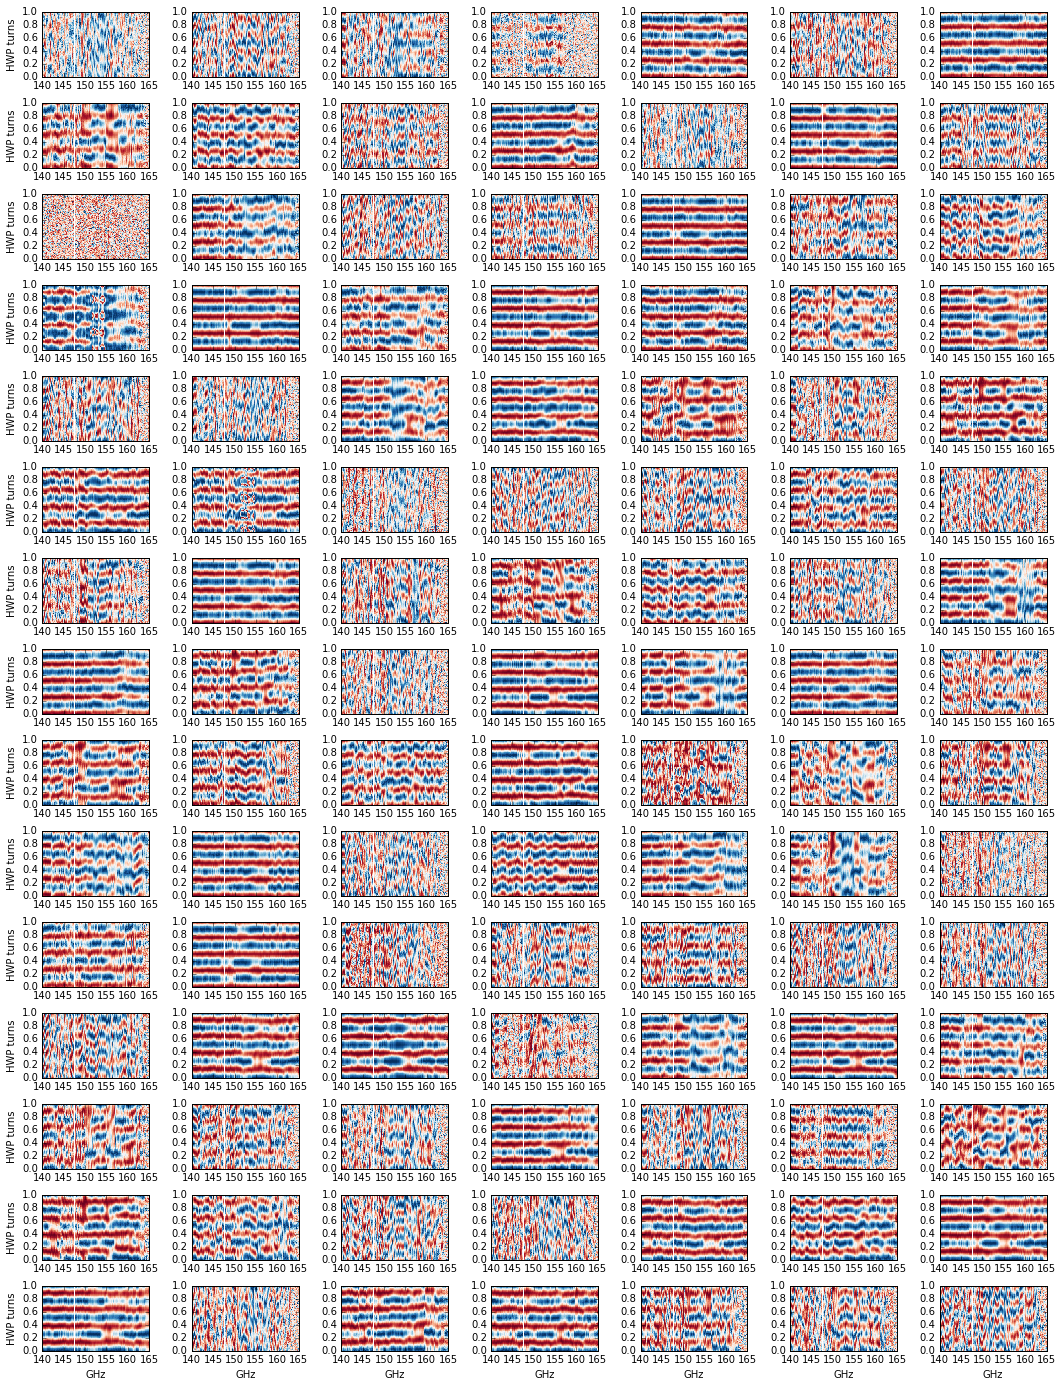

In [135]:
fig,axs = subplots(15,7,figsize=(18,24))
fig.subplots_adjust(wspace=0.4,hspace=0.4)
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows()])
    ffr = ffr/ffr.max(0)[None,:]
    angle = (det.hwp_motor_steps*3.6).values.astype('float')
    freq = det.mmw_frequency.iloc[0]/1e9
    ax.imshow(ffr,cmap=cm.RdBu,aspect='auto',interpolation='nearest',extent=[freq.min(),freq.max(),0,1])
    #ax.pcolormesh(freq,angle,ffr,cmap=cm.RdBu)
    #7/0
    #ax.set_ylim(0,360)
    #ax.set_xlim(freq.min(),freq.max())
for ax in axs[:,0]:
    ax.set_ylabel('HWP turns')
for ax in axs[-1,:]:
    ax.set_xlabel('GHz')

In [59]:
ffr.shape

(100, 200)

In [161]:
#det = df[df.number==22]
ffr = np.array([row.fractional_frequency_response for _,row in df.iterrows()])

In [212]:
ffr.shape

(100, 128, 200)

In [163]:
ffr.shape=(100,128,200)

In [164]:
ffz = np.fft.rfft(ffr,axis=0)

In [214]:
ffz.shape

(51, 128, 200)

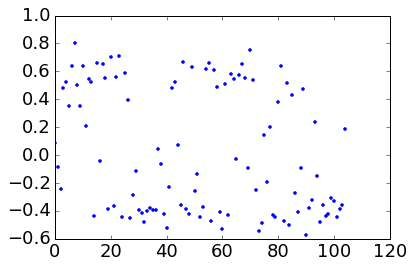

In [221]:
plot(np.nanmedian(np.angle(np.exp(-1j*np.pi/2)*ffz[4,:105,:])/np.pi,axis=1),'.')

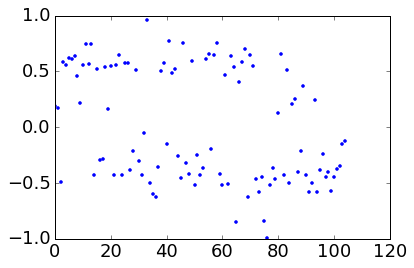

In [224]:
plot(np.angle(np.exp(-1j*np.pi/2)*ffz[4,:105,33])/np.pi,'.')

In [227]:
pola = np.angle(np.exp(-1j*np.pi/2)*ffz[4,:,33])/np.pi > 0

In [269]:
valid = (np.abs(2*ffz[4,:,33]/ffz[0,:,33]) >0.5) & (np.arange(128)<105)

In [168]:
ffn = ffr/ffr.max(0)

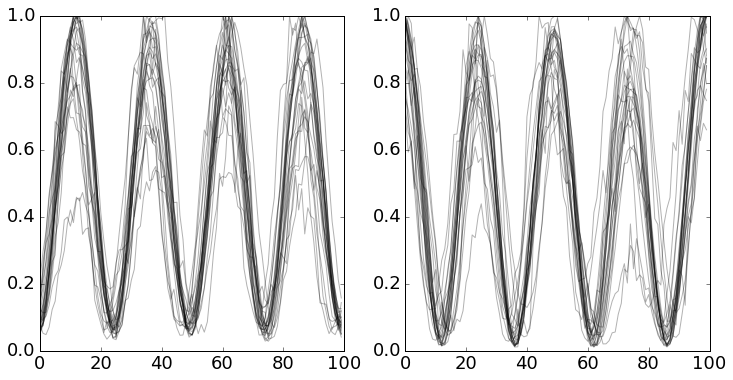

In [242]:
fig,axs = subplots(1,2,figsize=(12,6))
_=axs[0].plot(ffn[:,(pola & valid),33],'k',alpha=.3)
_=axs[1].plot(ffn[:,(~pola & valid),33][:,:105],'k',alpha=.3)


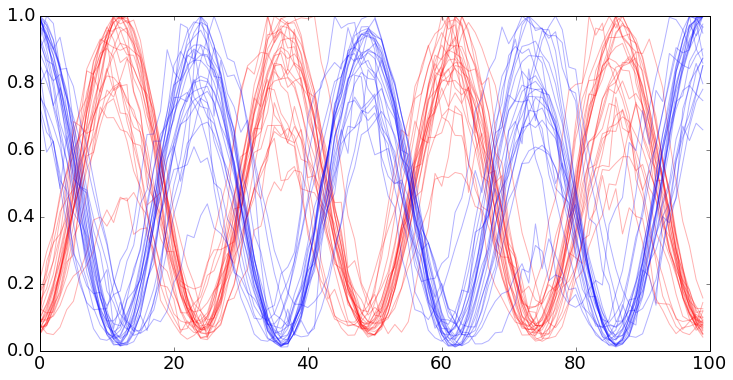

In [244]:
fig,axs = subplots(1,1,figsize=(12,6))
_=axs.plot(ffn[:,(pola & valid),33],'r',alpha=.3)
_=axs.plot(ffn[:,(~pola & valid),33][:,:105],'b',alpha=.3)


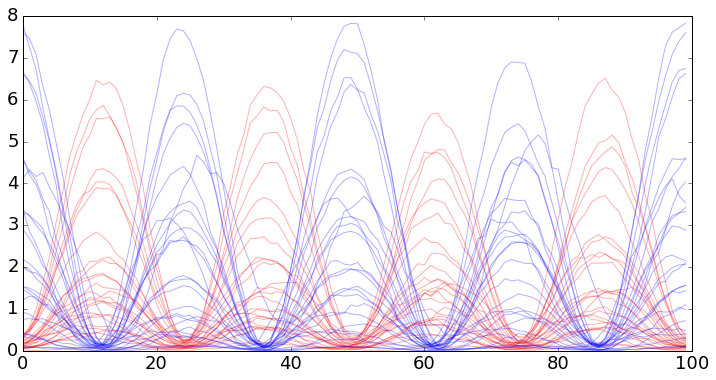

In [246]:
fig,axs = subplots(1,1,figsize=(12,6))
_=axs.plot(1e6*ffr[:,(pola & valid),33],'r',alpha=.3)
_=axs.plot(1e6*ffr[:,(~pola & valid),33][:,:105],'b',alpha=.3)


In [272]:
np.save('/data/readout/archive/2016-10-20-jpl-lf-2-pola-relaxed.npy',np.flatnonzero(pola&valid))

In [273]:
np.save('/data/readout/archive/2016-10-20-jpl-lf-2-polb-relaxed.npy',np.flatnonzero(~pola&valid))

In [266]:
pola_f0 = np.array([df.iloc[k].res_f_0 for k in np.flatnonzero(pola&valid)])
polb_f0 = np.array([df.iloc[k].res_f_0 for k in np.flatnonzero(~pola&valid)])

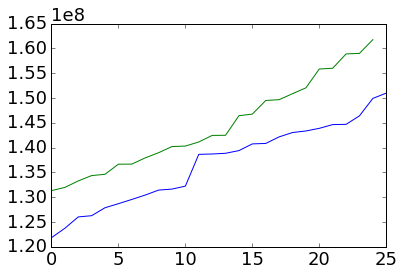

In [267]:
plot(pola_f0)
plot(polb_f0)

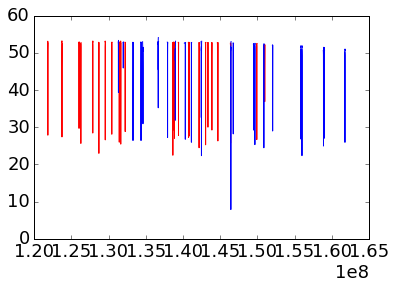

In [268]:
for k in np.flatnonzero(pola&valid):
    row = df.iloc[k]
    plot(row.res_model_frequency,dB(row.res_model_s21),'r')
for k in np.flatnonzero(~pola&valid):
    row = df.iloc[k]
    plot(row.res_model_frequency,dB(row.res_model_s21),'b')

In [169]:
p40=np.abs(2*ffz[4,:,:]/ffz[0,:,:])

In [170]:
p40.shape

(128, 200)

33
0.909434610367
33
0.94972458363


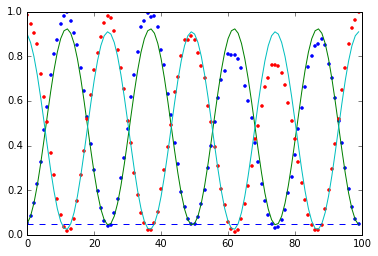

In [189]:
na = 22
pa = p40[na,:]
fidx = np.nanargmax(pa)
print fidx
plot(ffn[:,na,fidx],'.')
a = np.zeros_like(ffz[:,na,fidx])
a[4]=ffz[4,na,fidx]
a[0] = ffz[0,na,fidx]
plot(np.fft.irfft(a)/ffr[:,na,fidx].max())
print 2*np.abs(a[4]/a[0])
na = 24
pa = p40[na,:]
fidx = np.nanargmax(pa)
print fidx
plot(ffn[:,na,fidx],'.')
a = np.zeros_like(ffz[:,na,fidx])
a[4]=ffz[4,na,fidx]
a[0] = ffz[0,na,fidx]
print 2*np.abs(a[4]/a[0])
plot(np.fft.irfft(a)/ffr[:,na,fidx].max())
axhline(0.05,linestyle='--')

33
0.909434610367
33
0.94972458363


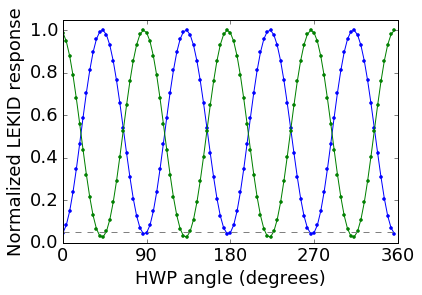

In [211]:
rcParams['font.size']=18
angle = np.arange(100)*3.6
na = 22
pa = p40[na,:]
fidx = np.nanargmax(pa)
print fidx
#plot(ffn[:,na,fidx],'.')
a = np.zeros_like(ffz[:,na,fidx])
a[4]=ffz[4,na,fidx]
a[8]=ffz[8,na,fidx]
a[0] = ffz[0,na,fidx]

y =np.fft.irfft(a)
plot(angle,y/y.max(),'.-')
#plot(np.fft.irfft(a)/ffr[:,na,fidx].max())
print 2*np.abs(a[4]/a[0])
na = 24
pa = p40[na,:]
fidx = np.nanargmax(pa)
print fidx
#plot(ffn[:,na,fidx],'.')
a = np.zeros_like(ffz[:,na,fidx])
a[4]=ffz[4,na,fidx]
#a[8]=ffz[8,na,fidx]
a[0] = ffz[0,na,fidx]
print 2*np.abs(a[4]/a[0])
y =np.fft.irfft(a)
plot(angle,y/y.max(),'.-')
#plot(np.fft.irfft(a)/ffr[:,na,fidx].max())
axhline(0.05,linestyle='--',color='gray')
ylim(0,1.05)
xlabel('HWP angle (degrees)')
ylabel('Normalized LEKID response')
xlim(-0.01,360.01)
gca().xaxis.set_major_locator(MultipleLocator(90))
savefig('/home/gjones/Dropbox/proposal_figures/jpl_lf_2_cw_144.1_GHz_hwp_4th_harm.pdf',bbox_inches='tight')

In [210]:
freq[33]

144.1457286432161

In [205]:
.95/1.05

0.9047619047619047

In [190]:
p40.shape

(128, 200)

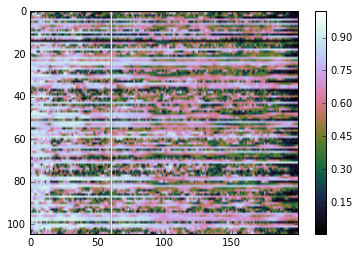

In [192]:
imshow(p40[:105,:],aspect='auto',cmap=cm.cubehelix)
colorbar()

In [187]:
freq[33]

144.1457286432161

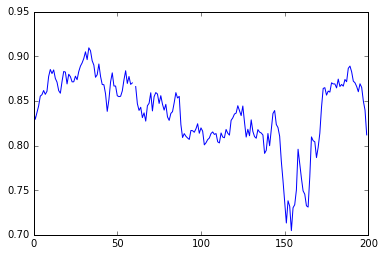

In [175]:
plot(pa)

In [88]:
np.abs(ffz[4,100]/ffz[0,100])

0.34910696179993744

In [103]:
y = np.sin(np.arange(100)*8*np.pi/100.)+1

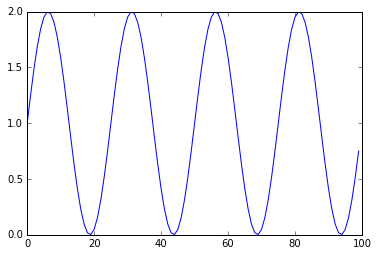

In [104]:
plot(y)

In [111]:
fy = np.fft.fft(y)

In [115]:
np.abs(2*fy[4]/fy[0])

1.0

In [145]:
ffn = ffr/ffr.max(0)[None,:]

In [148]:
ffn.argmin(0)

array([24, 49, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74,
       74, 74, 74, 75, 74, 74, 24, 24, 24, 24, 74, 74, 24, 74, 75, 74, 74,
       74, 74, 74, 24, 24,  0, 75, 75, 75, 75, 75, 25, 99, 49, 74, 74, 74,
       74, 74, 74, 74, 74, 74, 74, 74, 74,  0, 74, 74, 74, 74, 74, 74, 74,
       75, 74, 74, 74, 99, 99, 24, 24,  0, 24, 24, 24, 99, 24,  0,  0,  0,
        0,  0,  0, 24, 99, 99,  0, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
       99, 99, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74,
       74, 74, 75, 75, 75, 75, 74, 24, 75, 24, 25, 25, 25, 25, 24, 24, 24,
       25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 23, 23, 23, 48, 24, 98, 24, 74, 24, 24, 25, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 25, 99, 50,  0, 99, 49, 99, 24, 24,
        0, 50, 24, 99, 49, 49, 99, 50,  0,  0, 50, 50, 75])

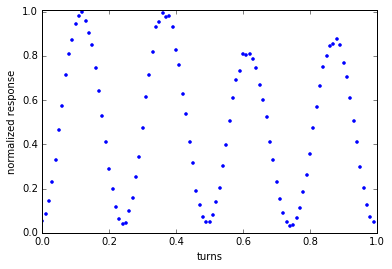

In [160]:
_=plot(np.arange(100)/100.,ffr[:,33]/ffr[:,33].max(),'.')
ylim(0,1.01)
xlabel('turns')
ylabel('normalized response')

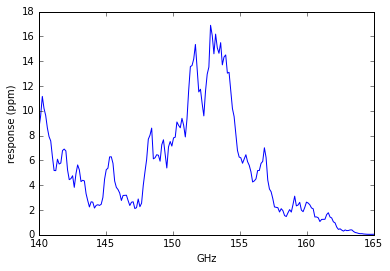

In [130]:
plot(freq,ffr[37,:]*1e6)
ylabel('response (ppm)')
xlabel('GHz')

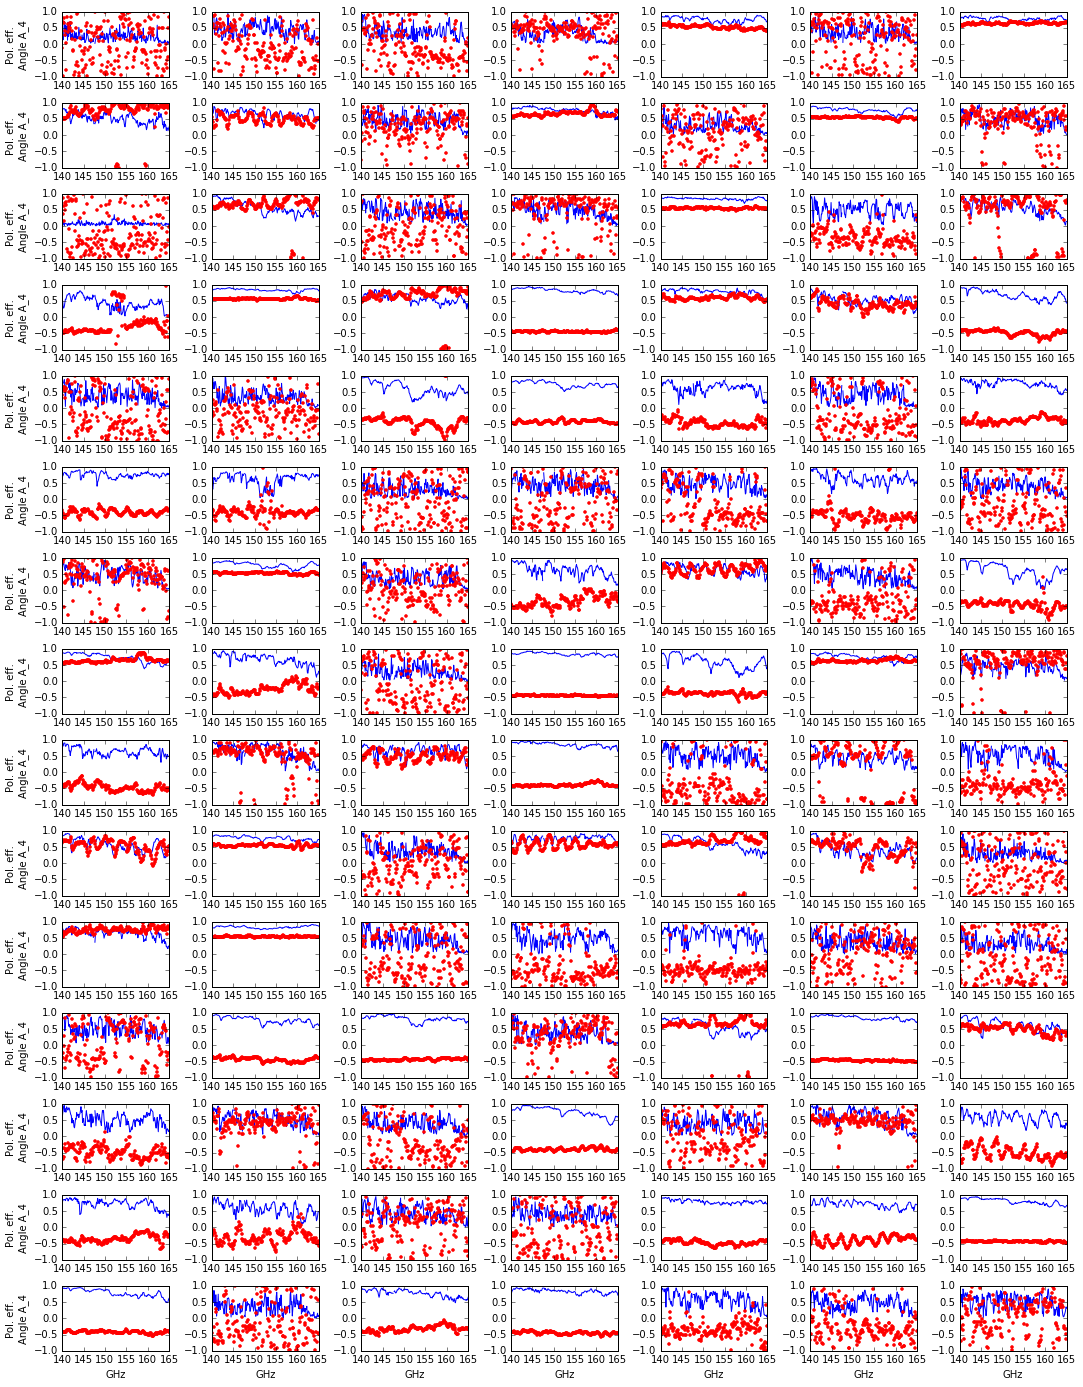

In [138]:
fig,axs = subplots(15,7,figsize=(18,24))
fig.subplots_adjust(wspace=0.4,hspace=0.4)
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows()])
    ffr = ffr/ffr.max(0)[None,:]
    ffz = np.fft.rfft(ffr,axis=0)
    #angle = (det.hwp_motor_steps*3.6).values.astype('float')
    freq = det.mmw_frequency.iloc[0]/1e9
    #ax.imshow(ffr,cmap=cm.RdBu,aspect='auto',interpolation='nearest')
    ax.plot(freq,np.abs(2*ffz[4,:]/ffz[0,:]))
    ax.plot(freq,np.angle(np.exp(-1j*np.pi/2)*ffz[4,:])/(np.pi),'r.')
    #ax.pcolormesh(freq,angle,ffr,cmap=cm.RdBu)
    #7/0
    ax.set_ylim(-1,1)
    #ax.set_xlim(freq.min(),freq.max())
for ax in axs[:,0]:
    ax.set_ylabel('Pol. eff.\nAngle A_4')
for ax in axs[-1,:]:
    ax.set_xlabel('GHz')

In [118]:
np.argmin(np.abs(20e-3-((np.array([1,2,5])[None,:])*((10.**np.arange(-9,1))[:,None])).flatten()[1:-2]))

21

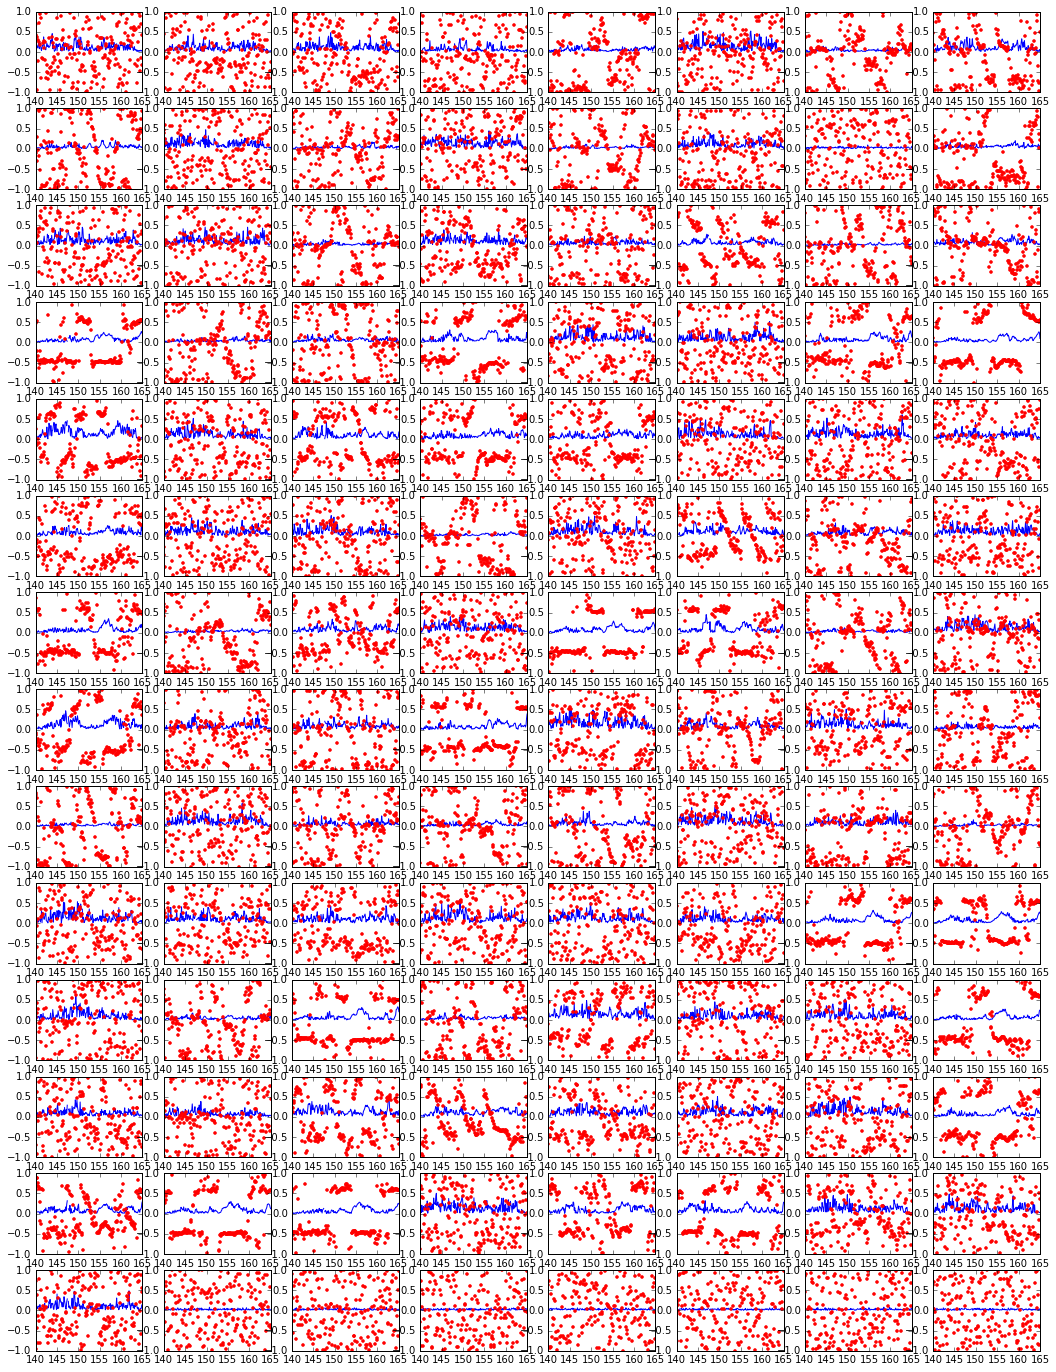

In [63]:
fig,axs = subplots(14,8,figsize=(18,24))
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows()])
    ffr = ffr/ffr.max(0)[None,:]
    ffz = np.fft.rfft(ffr,axis=0)
    #angle = (det.hwp_motor_steps*3.6).values.astype('float')
    freq = det.mmw_frequency.iloc[0]/1e9
    #ax.imshow(ffr,cmap=cm.RdBu,aspect='auto',interpolation='nearest')
    ax.plot(freq,np.abs(ffz[2,:]/ffz[0,:]))
    ax.plot(freq,np.angle(np.exp(-1j*np.pi/2)*ffz[2,:])/(np.pi),'r.')
    #ax.pcolormesh(freq,angle,ffr,cmap=cm.RdBu)
    #7/0
    ax.set_ylim(-1,1)
    #ax.set_xlim(freq.min(),freq.max())

In [72]:
row = det.iloc[0]

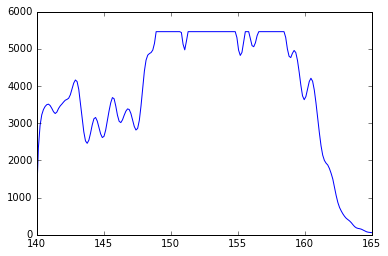

In [78]:
plot(freq,row.lockin_rms_voltage*1e6)

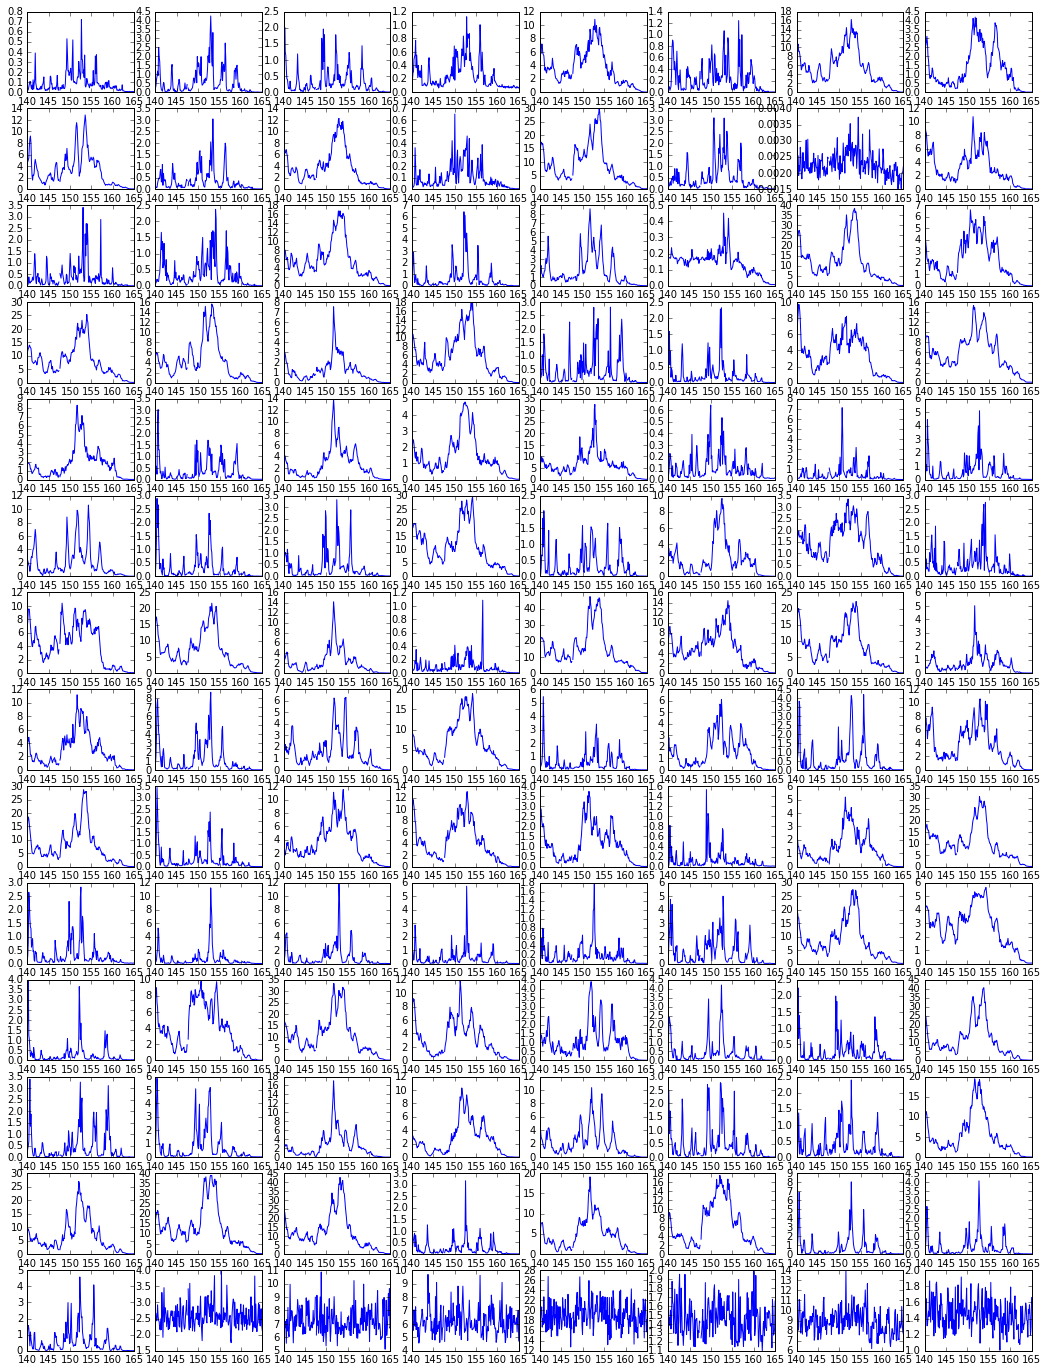

In [71]:
fig,axs = subplots(14,8,figsize=(18,24))
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows()])
    #ffr = ffr/ffr.max(0)[None,:]
    ffz = np.fft.rfft(ffr,axis=0)
    #angle = (det.hwp_motor_steps*3.6).values.astype('float')
    freq = det.mmw_frequency.iloc[0]/1e9
    #ax.imshow(ffr,cmap=cm.RdBu,aspect='auto',interpolation='nearest')
    ax.plot(freq,ffr.ptp(axis=0)*1e6)
#    ax.plot(freq,np.angle(np.exp(-1j*np.pi/2)*ffz[2,:])/(np.pi),'r.')
    #ax.pcolormesh(freq,angle,ffr,cmap=cm.RdBu)
    #7/0
#    ax.set_ylim(-1,1)
    #ax.set_xlim(freq.min(),freq.max())

In [57]:
ax

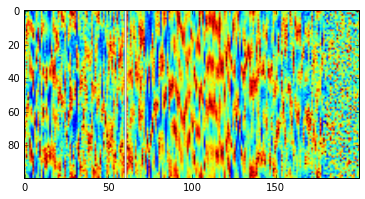

In [56]:
imshow(ffr)

In [23]:
det = df[df.number==0]

In [44]:
ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows()])

In [45]:
ffr.shape

(100, 200)

In [50]:
det.mmw_frequency.ix[0].shape

KeyError: 0

In [43]:
det.mmw_frequency.ix[0].shape

(200,)

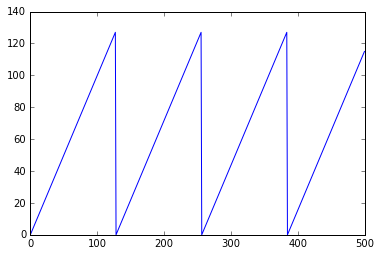

In [41]:
plot(df.number.values[:500])

In [24]:
det.shape

(100, 93)

In [39]:
det.hittite_frequency

0        10500000000
128      13750000000
256      13750000000
384      13750000000
512      13750000000
640      13750000000
768      13750000000
896      13750000000
1024     13750000000
1152     13750000000
1280     13750000000
1408     13750000000
1536     13750000000
1664     13750000000
1792     13750000000
1920     13750000000
2048     13750000000
2176     13750000000
2304     13750000000
2432     13750000000
2560     13750000000
2688     13750000000
2816     13750000000
2944     13750000000
3072     13750000000
3200     13750000000
3328     13750000000
3456     13750000000
3584     13750000000
3712     13750000000
            ...     
8960     13750000000
9088     13750000000
9216     13750000000
9344     13750000000
9472     13750000000
9600     13750000000
9728     13750000000
9856     13750000000
9984     13750000000
10112    13750000000
10240    13750000000
10368    13750000000
10496    13750000000
10624    13750000000
10752    13750000000
10880    13750000000
11008    1375

In [36]:
(det.hwp_motor_steps*3.6).values

array([nan, 3.6, 7.2, 10.8, 14.4, 18.0, 21.6, 25.2, 28.8, 32.4, 36.0, 39.6,
       43.2, 46.800000000000004, 50.4, 54.0, 57.6, 61.2, 64.8, 68.4, 72.0,
       75.60000000000001, 79.2, 82.8, 86.4, 90.0, 93.60000000000001, 97.2,
       100.8, 104.4, 108.0, 111.60000000000001, 115.2, 118.8, 122.4, 126.0,
       129.6, 133.20000000000002, 136.8, 140.4, 144.0, 147.6,
       151.20000000000002, 154.8, 158.4, 162.0, 165.6, 169.20000000000002,
       172.8, 176.4, 180.0, 183.6, 187.20000000000002, 190.8, 194.4, 198.0,
       201.6, 205.20000000000002, 208.8, 212.4, 216.0, 219.6,
       223.20000000000002, 226.8, 230.4, 234.0, 237.6, 241.20000000000002,
       244.8, 248.4, 252.0, 255.6, 259.2, 262.8, 266.40000000000003, 270.0,
       273.6, 277.2, 280.8, 284.40000000000003, 288.0, 291.6, 295.2, 298.8,
       302.40000000000003, 306.0, 309.6, 313.2, 316.8, 320.40000000000003,
       324.0, 327.6, 331.2, 334.8, 338.40000000000003, 342.0, 345.6, 349.2,
       352.8, 356.40000000000003], dtype=obje

In [28]:
det['fractional_frequency_response'].values.shape

(100,)

In [11]:
len(allframe)

1

In [12]:
f = allframes[0]

In [13]:
f.shape

(128, 93)

In [7]:
ncf = NCFile(files[0],cache_s21_raw=True)

In [8]:
mmwsl = ncf.MMWSweepList0

In [9]:
df = mmwsl.to_dataframe()

In [10]:
df.shape

(128, 93)

In [12]:
df['hwp_angle'] = 3.6

In [13]:
df.columns

Index([                     u'analysis_epoch',
                            u'folded_s21_raw',
                                  u'folded_x',
             u'fractional_frequency_response',
                         u'hittite_frequency',
                         u'hittite_output_on',
                         u'hittite_power_dBm',
                    u'hwp_motor_index_switch',
                           u'hwp_motor_steps',
                 u'lockin_detection_harmonic',
                     u'lockin_identification',
                u'lockin_input_configuration',
                     u'lockin_input_coupling',
                 u'lockin_input_notch_filter',
             u'lockin_input_shield_grounding',
                              u'lockin_local',
                u'lockin_output_filter_slope',
                u'lockin_reference_frequency',
                    u'lockin_reference_phase',
                   u'lockin_reference_source',
                  u'lockin_reference_trigger',
             

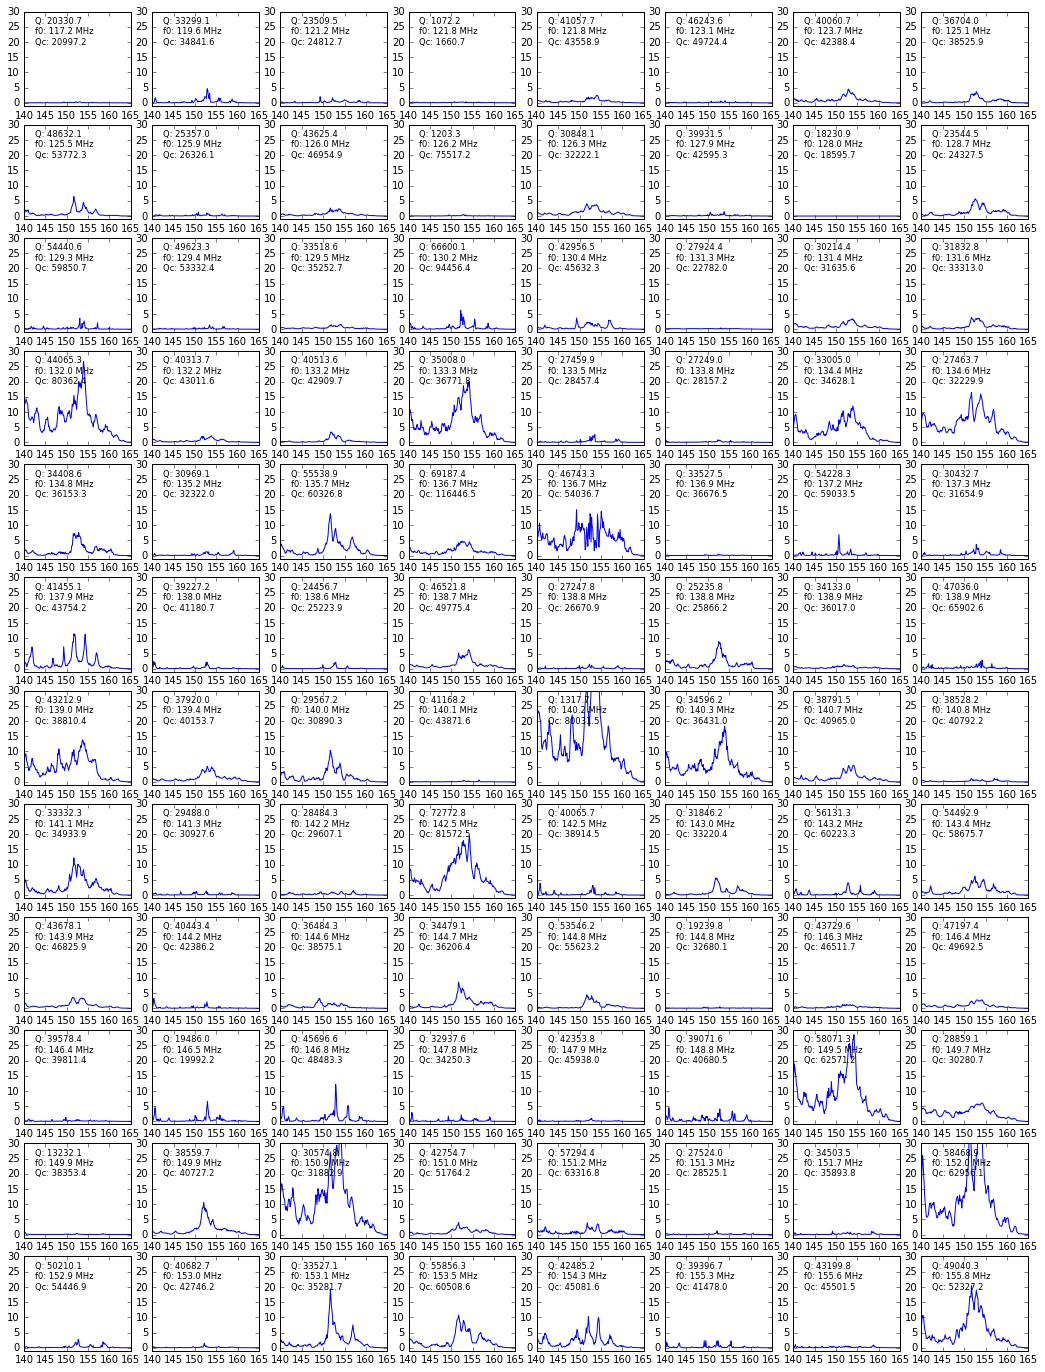

In [11]:
fig,axs = subplots(12,8,figsize=(18,24))
for k,row in df.iterrows():
    if k >=96:
        break
    ax = axs.flatten()[k]
    try:
        ax.plot(row.mmw_frequency/1e9,1e6*row.fractional_frequency_response)
        ax.text(0.1,0.95,("Q: %.1f\nf0: %.1f MHz\nQc: %.1f" %(row.res_Q,row.res_f_0/1e6,1/np.real(1/row.res_Q_e)[()])),
               transform=ax.transAxes,size='small',va='top')
    except ValueError:
        pass
    ax.set_ylim(-1,30)